In [2]:
%matplotlib inline 
#widget
import sys 
import xarray as xr
import numpy as np
import os 
import warnings
import yaml
from random import randint
import math
from datetime import datetime, timedelta

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

In [3]:
config = ['/home/jvalenti/scratch/OParcels_runs/Parcels_outfall/outfall_runs.yaml']
path_runs = '/home/jvalenti/MOAD/results/Graham/' 
paths = path(0)
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

path_NEMO = make_prefix(datetime(2019, 1, 1),paths['NEMO'])

jjii = xr.open_dataset('~/MOAD/grid/grid_from_lat_lon_mask999.nc')
finder(jjii,48,-123)

(193, 200)

In [4]:
finder(jjii,49.303153019596145, -123.78651388330361)

(500, 246)

In [5]:
coords = xr.open_dataset('/home/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
mask = xr.open_dataset('/home/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc')

Text(0.5, 1.0, 'Salish Sea subregions')

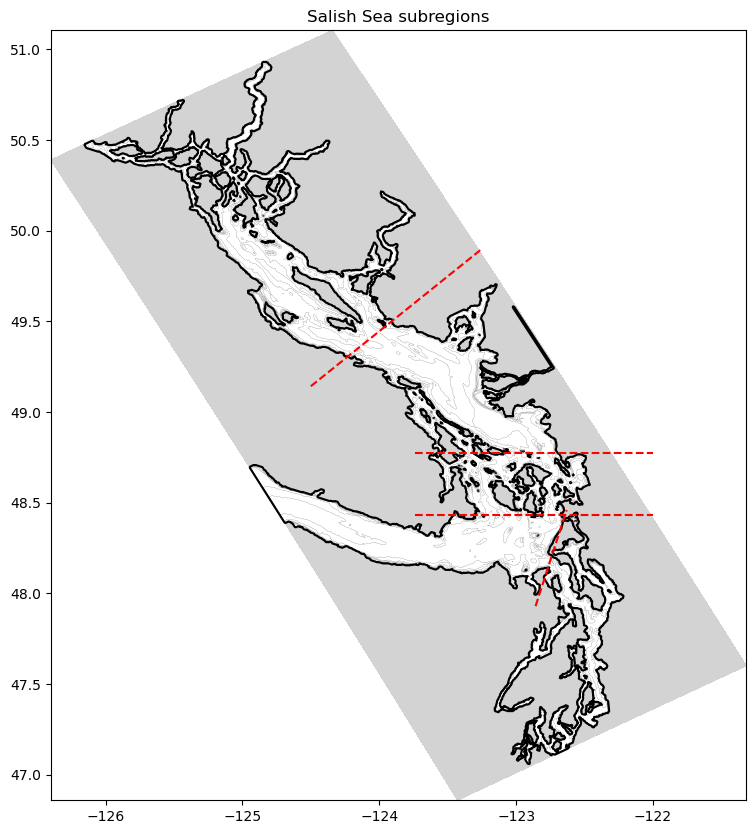

In [6]:
from matplotlib import pyplot as plt, animation, rc,colors
import cmocean
cm = cmocean.cm.dense

fig, ax = plt.subplots(1,1,figsize=(10, 10))

ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
#aa = ax.hist2d(DS.lon,DS.lat,100,cmap =cm,vmin=1e-5,vmax=2000)
ax.set_aspect(1/np.sin(np.deg2rad(49)))
Xline = np.linspace(-124.5,-122,100)
yline0 = (7/3)*Xline+334.6
yline1 = (20/33)*Xline+124.597
yline2 = np.zeros_like(Xline)+48.43
yline3 = np.zeros_like(Xline)+48.774
plt.plot(Xline[65:75],yline0[65:75],'r--')
plt.plot(Xline[:50],yline1[:50],'r--')
plt.plot(Xline[30:],yline2[30:],'r--')
plt.plot(Xline[30:],yline3[30:],'r--')

plt.title('Salish Sea subregions')

In [7]:
import pandas as pd
Point_At = pd.read_csv('Book1.csv')
Time=np.linspace(0,365,8017)

Source = pd.read_csv('Outfall_deploy.csv')
Source = Source.rename(columns={'Lat': 'lat', 'Lon': 'lon'})

In [8]:
runs = {'250 s':['alpha120190101.nc',2],'500 s':['alpha_1_jan.nc',2],'1,000 s':['alpha220190101.nc',2],'2,500 s':['Runs_alpha0220190101_.nc',1],'5,000 s':['Run_Enero20190101_.nc',2],'10,000 s':['Runs_alpha0520190101_.nc',1],'50,000 s':['Runs_alpha0120190101_.nc',1]}

months = {'Jan':['Run_Enero20190101_.nc',1],'Feb':['Run_Febrero20190201_.nc',32],'Mar':['Run_Marzo20190301_.nc',61],'Jun':['Run_Junio20190601_.nc',152],'Jul':['Run_Julio20190701_.nc',183],'Aug':['Run_Agosto20190801_.nc',214]}

sub_areas=['Puget','JdF','Haro2','NSoG','CSSoG']
def cutting(data,area):
    if area=='Puget':
        data_new = data.loc[(data['lat']<48.43) & (data['lat']<(7/3)*data['lon']+334.6)]
    elif area=='JdF':
        data_new = pd.concat([data.loc[((data['lat']<48.43) & (data['lat']>(7/3)*data['lon']+334.6))],data.loc[((data['lat']>48.43) & (data['lat']<48.774) & (data['lon']<-124))]])
    elif area=='Haro':  
        data_new = data.loc[(data['lat']>48.43) & (data['lat']<48.774) & (data['lon']>-123.456) & (data['lon']<-123)]
    elif area=='Haro2':  
        data_new = data.loc[(data['lat']>48.43) & (data['lat']<48.774) & (data['lon']>-124)]
    elif area=='NSoG':
        data_new = data.loc[(data['lat']>(20/33)*data['lon']+124.597)]
    elif area=='CSSoG': 
        data_new = data.loc[(data['lat']>48.774)&(data['lat']<(20/33)*data['lon']+124.597)]
    else:
        print('Unrecognized subarea') 
        data_new = data
    return data_new

In [9]:
volume = (mask.e1t[0,:,:]*(mask.e2t[0,:,:])*(mask.e3t_0[0,:,:,:]))
maskt = mask.tmask[0,:,:,:]
total_volume = np.sum(maskt* volume)

In [10]:
concs = {'250 s':['alpha120190101.npy',2],'500 s':['alpha_1_jan.npy',2],'1,000 s':['alpha220190101.npy',2],'2,500 s':['Runs_alpha0220190101_.npy',1],'5,000 s':['Run_Enero20190101_.npy',1],'10,000 s':['Runs_alpha0520190101_.npy',1],'50,000 s':['Runs_alpha0120190101_.npy',1]}

alphs = {'250 s':250,'500 s':500,'1,000 s':1000,'2,500 s':2500,'5,000 s':5000,'10,000 s':10000,'50,000 s':50000}
xs =np.array(list(alphs.values()))
masktt=maskt[:,::3,::3]
conc_mean = []
weighted_nanmean =[]
weighted_q1 = []
weighted_q3 = []
conc_sd = []
weights = mask.e3t_0[0,:,::3,::3]
TD = np.nansum(np.where(masktt,weights,np.nan).ravel())
weights = np.where(masktt,weights,np.nan)/TD
for alp in alphs:
    conc = np.load(path_runs+concs[alp][0])/concs[alp][1]
    conc = np.where(masktt,conc,np.nan)
    masknan = ~np.isnan(conc)
    data_cleaned = conc[masknan]
    weights_cleaned = weights[masknan]
    weighted_mean=np.average(data_cleaned, weights=weights_cleaned)
    weighted_nanmean.append(weighted_mean)
    #conc_mean.append(np.nanmean(np.nanmean(np.nanmean(conc,axis=2),axis=1)))
    #conc_sd.append(np.nanstd(np.nanstd(np.nanstd(conc,axis=2),axis=1)))
#plt.plot(xs, weighted_nanmean, '.', label="data")

ys = weighted_nanmean
import scipy.optimize
def monoExp(x, m, t, b):
    return m * np.log(t * x) + b
# perform the fit
params, cv = scipy.optimize.curve_fit(monoExp, xs, ys)
m, t, b = params

# determine quality of the fit
squaredDiffs = np.square(ys - monoExp(xs, m, t, b))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

xs2 = np.arange(250,5.4e4)
ys2 = monoExp(xs2, m, t, b)
fig, ax = plt.subplots()
plt.plot(xs, ys, '.', label="data")
plt.plot(xs2, ys2, '--', label="fitted")
plt.title(r'Mean concentration in SalishSeaCast after 30 days run for different $\alpha$')

R² = 0.986193620267178


/tmp/ipykernel_2510503/4095599024.py:29: RuntimeWarning: invalid value encountered in log
  return m * np.log(t * x) + b


Text(0.5, 1.0, 'Mean concentration in SalishSeaCast after 30 days run for different $\\alpha$')

In [11]:
import math

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth.
    
    Parameters:
        lat1, lon1: Latitude and longitude of point 1 in decimal degrees.
        lat2, lon2: Latitude and longitude of point 2 in decimal degrees.
    
    Returns:
        Distance in kilometers.
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    r = 6371000  # Radius of Earth in kilometers
    return r * c

In [12]:
# travel_all = []
# for alpha in runs:
#     print(alpha)
#     ds = xr.open_dataset(path_runs+runs[alpha][0], decode_times=False)
#     x = np.linspace(0,31,ds.dims['obs']-1)
#     DS = ds.to_dataframe()
#     DS = DS.dropna()
    
#     dist_travel = []
#     for i in range(len(DS.lat)):
#         try: leni = len(DS.lat[i])
#         except KeyError:
#             break
#         dist_travel.append(haversine(DS.lat[i][0],DS.lon[i][0],DS.lat[i][leni-1],DS.lon[i][leni-1]))
#     travel_all.append(dist_travel)
# np.save('distance_travelled.npy',np.array(travel_all))

In [28]:
a=[]
for alpha in alphs:
    a.append(np.mean(np.load('distance_travelled'+str(alpha)+'.npy'))/1e3)

In [30]:
plt.plot(xs,a)